In [ ]:
## Import the libraries here in this cell
import numpy as np
import pandas as pd
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn import metrics
from sklearn.metrics import classification_report
import seaborn as sns
from torchvision.models import resnet18
from torch.utils.data import Subset
import torchvision.models as models

In [ ]:
batch_size = 32
learning_rate = 3e-4
epochs = 5
image_size = 28

In [ ]:
# Define the transformation for the dataset
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert to 3 channels
    transforms.ToTensor(),
    transforms.Resize(image_size),
    transforms.Normalize((0.5,), (0.5,))
])

# Download and import the training set
train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
test_data = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)


# Splitting dataset into train, val and test sets
train_data, val_data = torch.utils.data.random_split(train_dataset, [0.8, 0.2])

100%|██████████| 26421880/26421880 [00:01<00:00, 15479219.39it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 273168.74it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 4986718.35it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 5022627.82it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
trainloader = DataLoader(train_data, batch_size= batch_size, shuffle=True)
valloader = DataLoader(val_data, batch_size= batch_size, shuffle=False)
testloader = DataLoader(test_data, batch_size= batch_size, shuffle=False)

In [ ]:
model = models.resnet101(pretrained=True).to(device)
model.fc = nn.Linear(model.fc.in_features, len(train_dataset.classes)).to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:01<00:00, 147MB/s]


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4)
optimizer2 = optim.Adagrad(model.parameters(), lr=3e-4)
optimizer3 = optim.RMSprop(model.parameters(), lr=3e-4)

In [ ]:
epochs = 5
def train(model, trainloader, valloader, criterion, optimizer, device, epochs):
    model.train()

    t_loss = []
    v_loss = []

    for epoch in range(epochs):
        loss = 0
        correct_train = 0
        total_train = 0

        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            train_loss = criterion(outputs, labels)
            train_loss.backward()
            optimizer.step()

            loss += train_loss.item()

            _, pred = outputs.max(1)
            total_train += labels.size(0)
            correct_train += pred.eq(labels).sum().item()

        loss /= len(trainloader)
        t_loss.append(loss)

        train_accuracy = 100 * correct_train / total_train

        val_loss = 0

        with torch.no_grad():
            for inputs, label in valloader:
                inputs = inputs.to(device)
                label = label.to(device)

                outputs = model(inputs)
                valid_loss = criterion(outputs, label)
                val_loss += valid_loss.item()

        val_loss /= len(valloader)
        v_loss.append(val_loss)

        # Display the epoch losses
        print("epoch : {}/{}, recon loss = {:.8f}".format(epoch + 1, epochs, loss))
        print("epoch : {}/{}, valid loss = {:.8f}".format(epoch + 1, epochs, val_loss))

    return t_loss, v_loss, train_loss/len(trainloader), train_accuracy



In [ ]:
def test(model, testloader, criterion, device):
    model.eval()
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)

            # Calculate accuracy
            _, pred = outputs.max(1)
            total_test += labels.size(0)
            correct_test += pred.eq(labels).sum().item()

    test_accuracy = 100 * correct_test / total_test

    return test_accuracy


In [ ]:
def plot_accuracies(train_accuracies, test_accuracies, epochs):

    # Your code here
    epochs = len(train_accuracies)
    plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, epochs + 1), test_accuracies, label='Test Accuracy')

    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Train and Test Accuracies vs Epochs')
    plt.legend()
    plt.show()


In [ ]:
train_losses, val_losses, train_loss_per_batch, train_accuracy = train(model, trainloader, valloader, criterion, optimizer, device, 10)
test_accuracy = test(model, testloader, criterion, device)

epoch : 1/10, recon loss = 0.41005977
epoch : 1/10, valid loss = 0.28731244
epoch : 2/10, recon loss = 0.27772911
epoch : 2/10, valid loss = 0.26719426
epoch : 3/10, recon loss = 0.24937597
epoch : 3/10, valid loss = 0.24348982
epoch : 4/10, recon loss = 0.21712839
epoch : 4/10, valid loss = 0.31852550
epoch : 5/10, recon loss = 0.19023638
epoch : 5/10, valid loss = 0.22311745
epoch : 6/10, recon loss = 0.16490926
epoch : 6/10, valid loss = 0.23362583
epoch : 7/10, recon loss = 0.15231898
epoch : 7/10, valid loss = 0.23003181
epoch : 8/10, recon loss = 0.13540157
epoch : 8/10, valid loss = 0.24235882
epoch : 9/10, recon loss = 0.11154298
epoch : 9/10, valid loss = 0.23309274
epoch : 10/10, recon loss = 0.09928939
epoch : 10/10, valid loss = 0.25032856


In [ ]:
train_accuracy

96.37916666666666

In [ ]:
test_accuracy

91.93

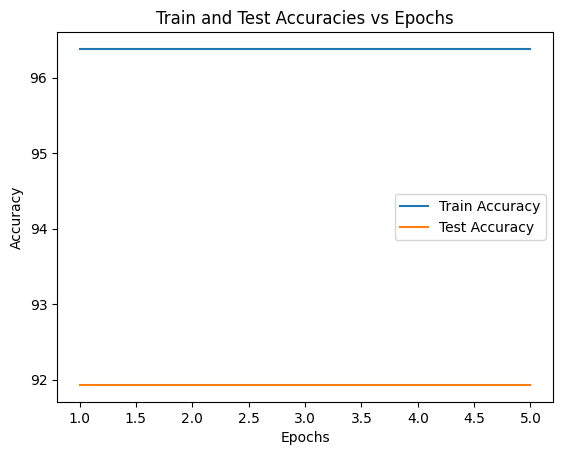

In [ ]:
train_accuracy = [train_accuracy] * epochs
test_accuracy = [test_accuracy] * epochs
plot_accuracies(train_accuracy, test_accuracy, epochs)

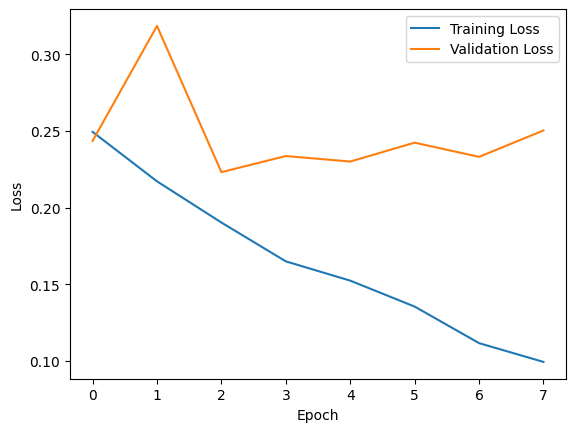

In [ ]:
plt.plot(train_losses[2:], label='Training Loss')
plt.plot(val_losses[2:], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
train_losses, val_losses, train_loss_per_batch, train_accuracy = train(model, trainloader, valloader, criterion, optimizer2, device, 10)
test_accuracy = test(model, testloader, criterion, device)

epoch : 1/10, recon loss = 0.46853031
epoch : 1/10, valid loss = 0.35964389
epoch : 2/10, recon loss = 0.29871222
epoch : 2/10, valid loss = 0.31811264
epoch : 3/10, recon loss = 0.24035281
epoch : 3/10, valid loss = 0.29671097
epoch : 4/10, recon loss = 0.20803235
epoch : 4/10, valid loss = 0.28776583
epoch : 5/10, recon loss = 0.18087693
epoch : 5/10, valid loss = 0.28505781
epoch : 6/10, recon loss = 0.15809000
epoch : 6/10, valid loss = 0.29002076
epoch : 7/10, recon loss = 0.13740912
epoch : 7/10, valid loss = 0.28670884
epoch : 8/10, recon loss = 0.12053670
epoch : 8/10, valid loss = 0.29638797
epoch : 9/10, recon loss = 0.11037458
epoch : 9/10, valid loss = 0.30087878
epoch : 10/10, recon loss = 0.09090310
epoch : 10/10, valid loss = 0.30641111


In [ ]:
train_accuracy

96.94166666666666

In [ ]:
test_accuracy

88.96

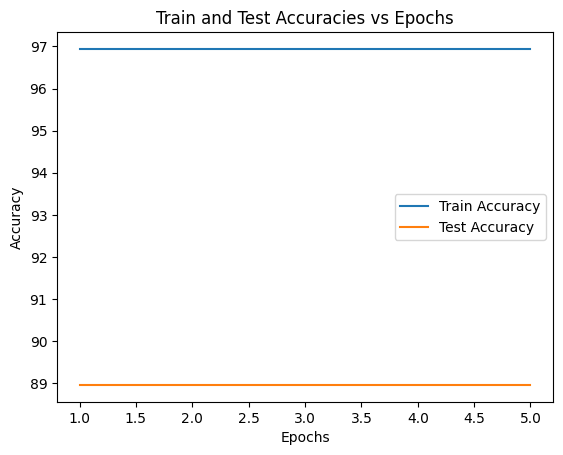

In [ ]:
train_accuracy = [train_accuracy] * epochs
test_accuracy = [test_accuracy] * epochs
plot_accuracies(train_accuracy, test_accuracy, epochs)

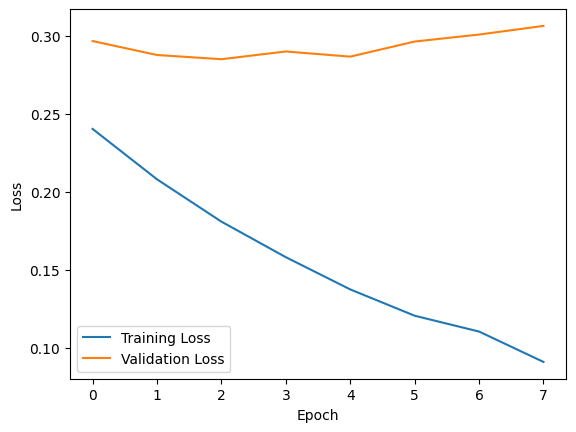

In [ ]:
plt.plot(train_losses[2:], label='Training Loss')
plt.plot(val_losses[2:], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
train_losses, val_losses, train_loss_per_batch, train_accuracy = train(model, trainloader, valloader, criterion, optimizer3, device, 10)
test_accuracy = test(model, testloader, criterion, device)

epoch : 1/10, recon loss = 0.42375290
epoch : 1/10, valid loss = 0.28919394
epoch : 2/10, recon loss = 0.28479514
epoch : 2/10, valid loss = 0.27835641
epoch : 3/10, recon loss = 0.23421827
epoch : 3/10, valid loss = 0.25238824
epoch : 4/10, recon loss = 0.20105639
epoch : 4/10, valid loss = 0.22791247
epoch : 5/10, recon loss = 0.17318272
epoch : 5/10, valid loss = 0.24199497
epoch : 6/10, recon loss = 0.15365886
epoch : 6/10, valid loss = 0.23527444
epoch : 7/10, recon loss = 0.12914390
epoch : 7/10, valid loss = 0.25189169
epoch : 8/10, recon loss = 0.11361237
epoch : 8/10, valid loss = 0.25312594
epoch : 9/10, recon loss = 0.10049827
epoch : 9/10, valid loss = 0.24340551
epoch : 10/10, recon loss = 0.09139885
epoch : 10/10, valid loss = 0.31069435


In [ ]:
train_accuracy

96.76666666666667

In [ ]:
test_accuracy

89.95

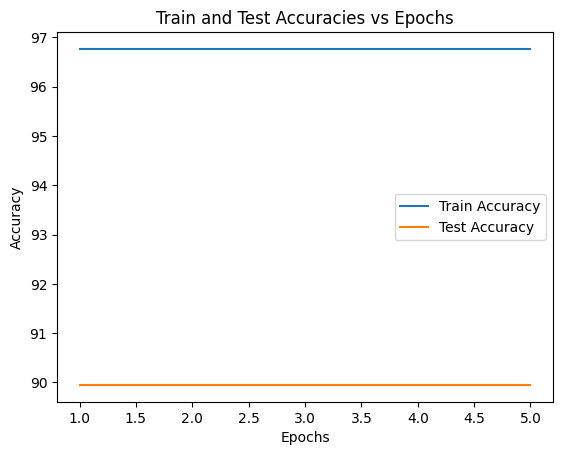

In [ ]:
train_accuracy = [train_accuracy] * epochs
test_accuracy = [test_accuracy] * epochs
plot_accuracies(train_accuracy, test_accuracy, epochs)

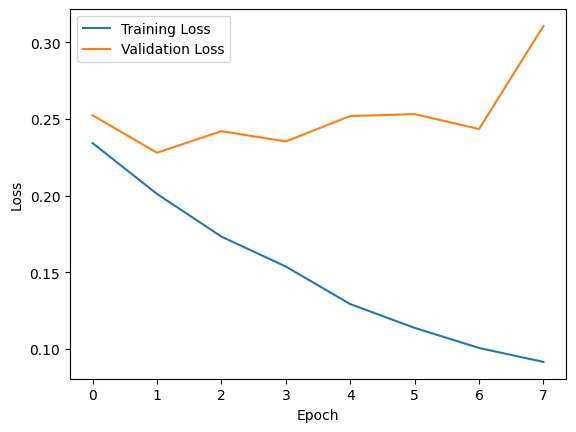

In [ ]:
plt.plot(train_losses[2:], label='Training Loss')
plt.plot(val_losses[2:], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()